### Mapping

In [1]:
import folium
import pandas as pd
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap

# Load your dataset
dataset_df = pd.read_excel('./dataset1/dataset.xlsx')
boundary_df = pd.read_excel('./dataset1/boundary.xlsx')

# Convert boundary corners into coordinates
coordinates = [tuple(map(float, corner.split(','))) for corner in boundary_df['Corners']]
if coordinates[0] != coordinates[-1]:
    coordinates.append(coordinates[0])  # Close the polygon

# Create a polygon for the land boundary
polygon = Polygon(coordinates)

# Define colormap function
def get_color(value, min_val, max_val):
    cmap = LinearSegmentedColormap.from_list("mycmap", ['blue', 'lime', 'red'])
    norm_value = (value - min_val) / (max_val - min_val)  # Normalize the value
    return cmap(norm_value)

# Define a parameter to visualize (example: nitrogen)
parameter = 'Nitrogen (mg/kg)'  # Change this to any other parameter if needed

# Get min and max values for the parameter
min_val = dataset_df[parameter].min()
max_val = dataset_df[parameter].max()

# Initialize Folium map
m = folium.Map(location=[coordinates[0][0], coordinates[0][1]], zoom_start=40)

# Add markers individually to the map
for _, row in dataset_df.iterrows():
    color = get_color(row[parameter], min_val, max_val)
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        color=f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}',  # Convert to hex
        fill=True,
        fill_color=f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}',
        fill_opacity=0.7,
        popup=f"{parameter}: {row[parameter]}"
    ).add_to(m)

# Add the boundary to the map
folium.PolyLine(locations=coordinates, color='blue', weight=2.5, opacity=1).add_to(m)

# Display the map
m.save('soil_data_no_cluster_map.html')
m  # To display inline in Jupyter


### Stat

In [2]:
# Generate data insights: Mean, Max, Min, Std Dev, Count
numeric_df = dataset_df[['Latitude', 'Longitude', 'Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']]
summary_df = pd.DataFrame({
    'Mean': numeric_df.mean(),
    'Max': numeric_df.max(),
    'Min': numeric_df.min(),
    'Std Dev': numeric_df.std(),
    'Count': numeric_df.count()
})


summary_df

,Mean,Max,Min,Std Dev,Count
Latitude,6.973861,6.974201,6.973541,0.000178,25
Longitude,79.943483,79.944086,79.942889,0.000357,25
Moisture (%),87.220000,98.500000,82.100000,3.455069,25
Temperature (C),27.712000,28.000000,27.000000,0.250533,25
EC (us/cm),185.160000,220.000000,101.000000,38.392360,25
Ph,7.348000,7.900000,7.100000,0.214321,25
Nitrogen (mg/kg),132.400000,143.000000,125.000000,5.267827,25
Posphorous (mg/kg),219.200000,237.000000,206.000000,11.003787,25
Potassium (mg/kg),231.640000,260.000000,208.000000,15.107614,25


### Area

In [3]:
area_sq_meters = polygon.area * (111320 ** 2)
area_acres = area_sq_meters * 0.000247105
print("Area in sq m:", area_sq_meters)


Area in sq m: 6778.461195569432


### IDW

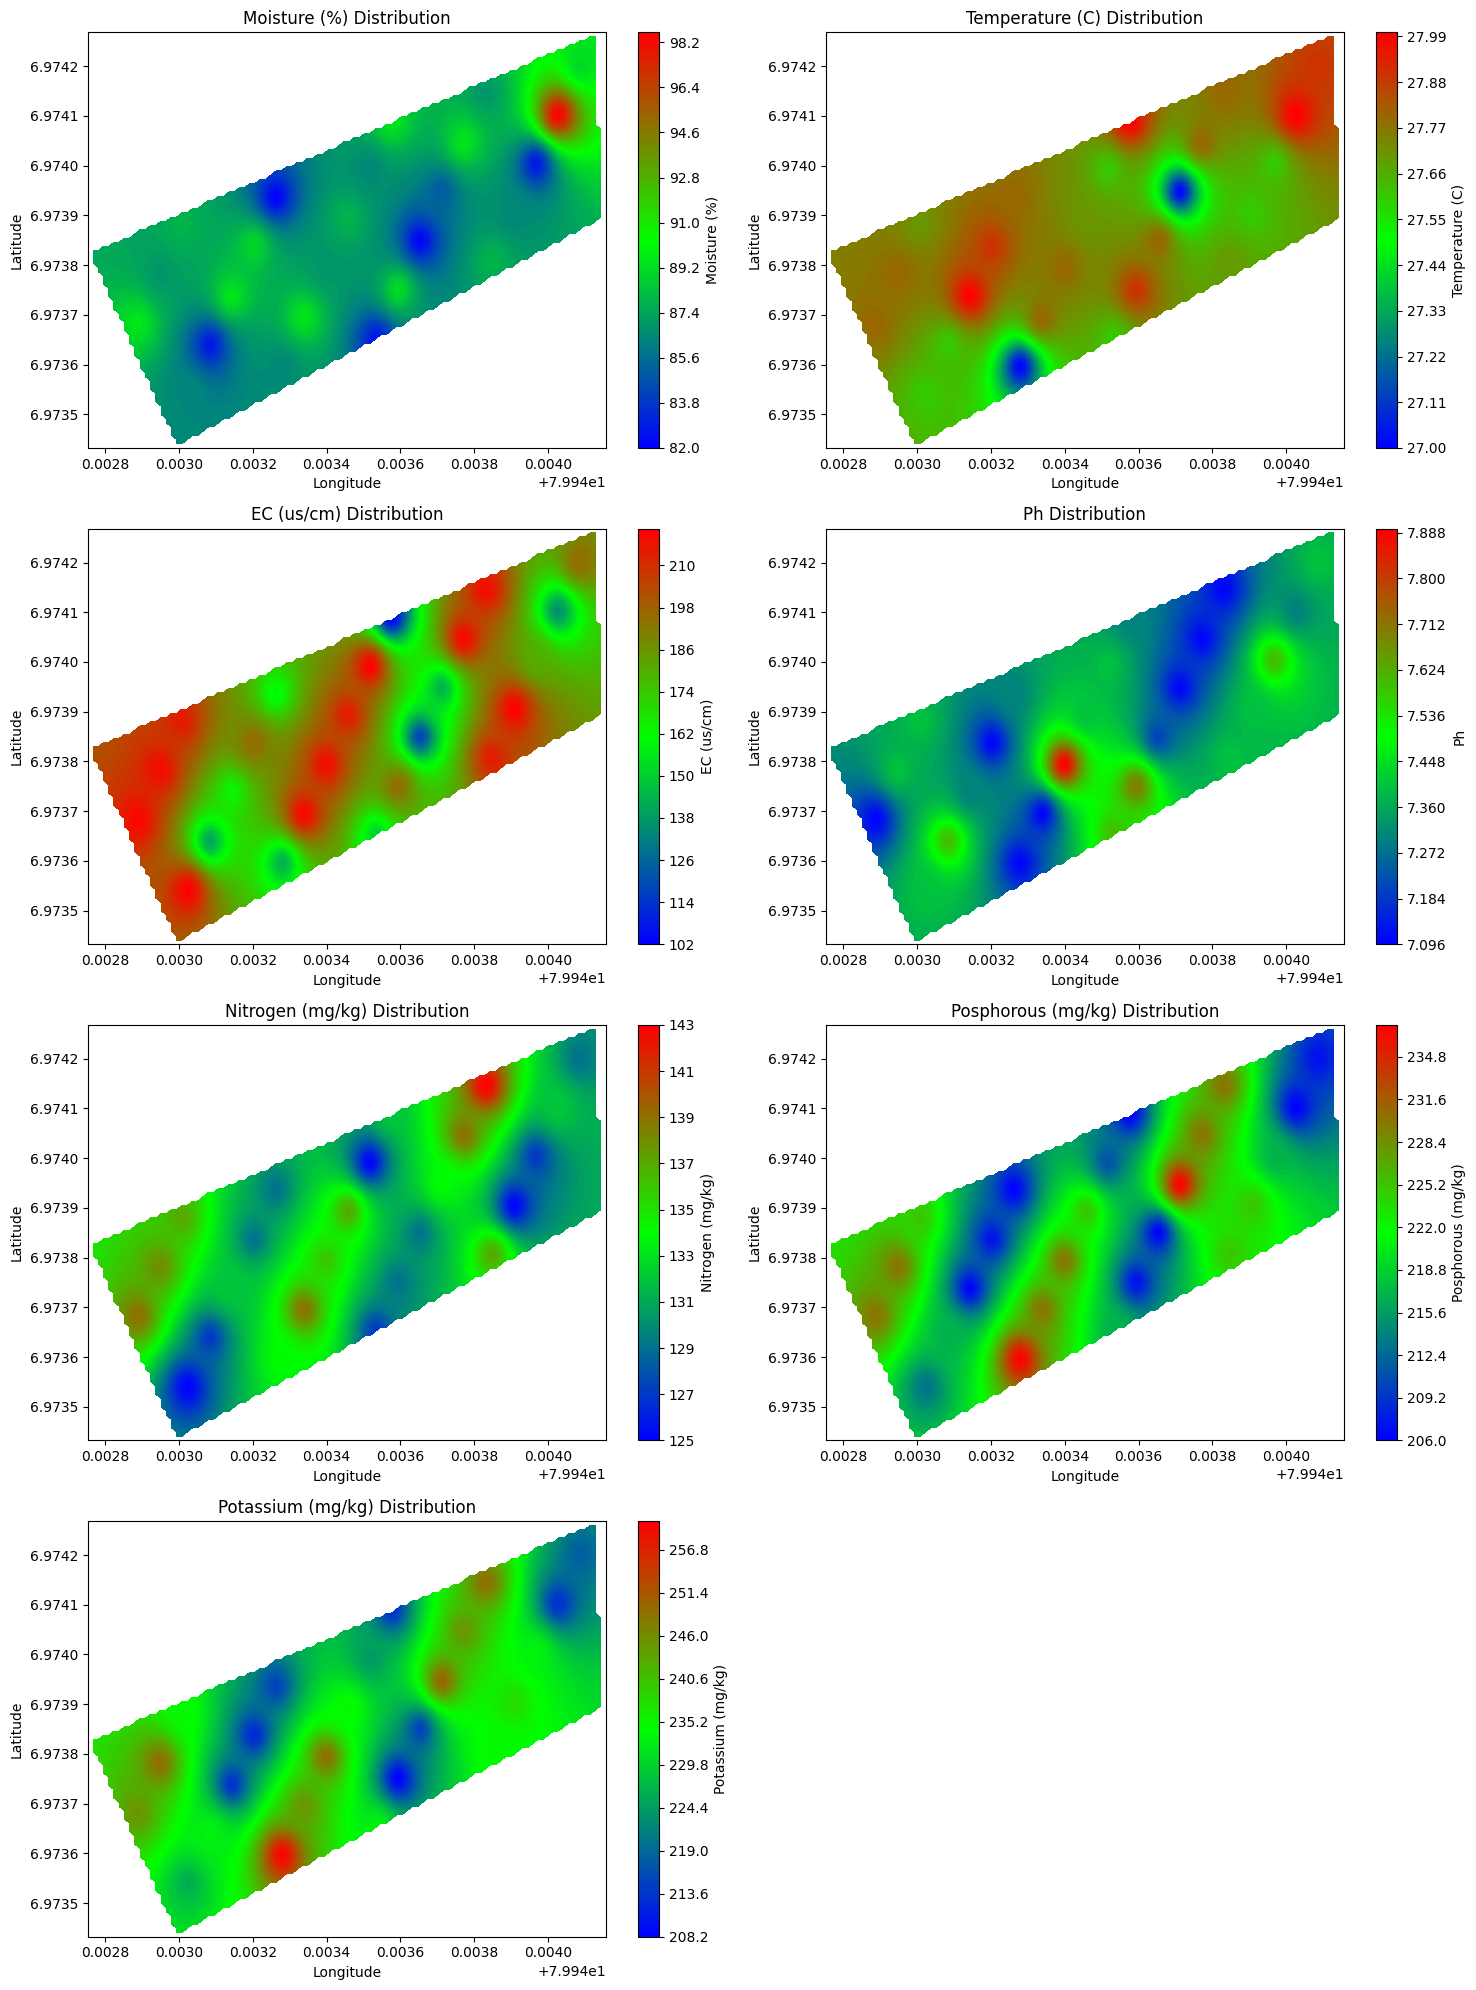

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter


parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']


def idw(x, y, z, xi, yi, power=2):
    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 + (y[:, None, None] - yi[None, :, :])**2)
    weights = 1 / (dist**power)
    weights[dist == 0] = np.inf
    z_idw = np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)
    return z_idw


min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:100j, min_lon:max_lon:100j]

nrows = len(parameters) // 2 if len(parameters) % 2 == 0 else (len(parameters) // 2) + 1
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()


for i, parameter in enumerate(parameters):
    
    x = dataset_df['Latitude'].values
    y = dataset_df['Longitude'].values
    z = dataset_df[parameter].values

    
    grid_z_idw = idw(x, y, z, grid_x, grid_y)

    
    mask = np.array([Point(lat, lon).within(polygon) for lat, lon in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_idw = np.ma.masked_array(grid_z_idw, ~mask.reshape(grid_z_idw.shape))

    
    cmap = LinearSegmentedColormap.from_list("mycmap", ['blue', 'lime', 'red'])
    contour = axs[i].contourf(grid_y, grid_x, grid_z_idw, cmap=cmap, levels=100)
    fig.colorbar(contour, ax=axs[i], label=parameter)
    axs[i].set_title(f'{parameter} Distribution')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')


if len(parameters) % 2 != 0:
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()
plt.show()


### IDW using a region

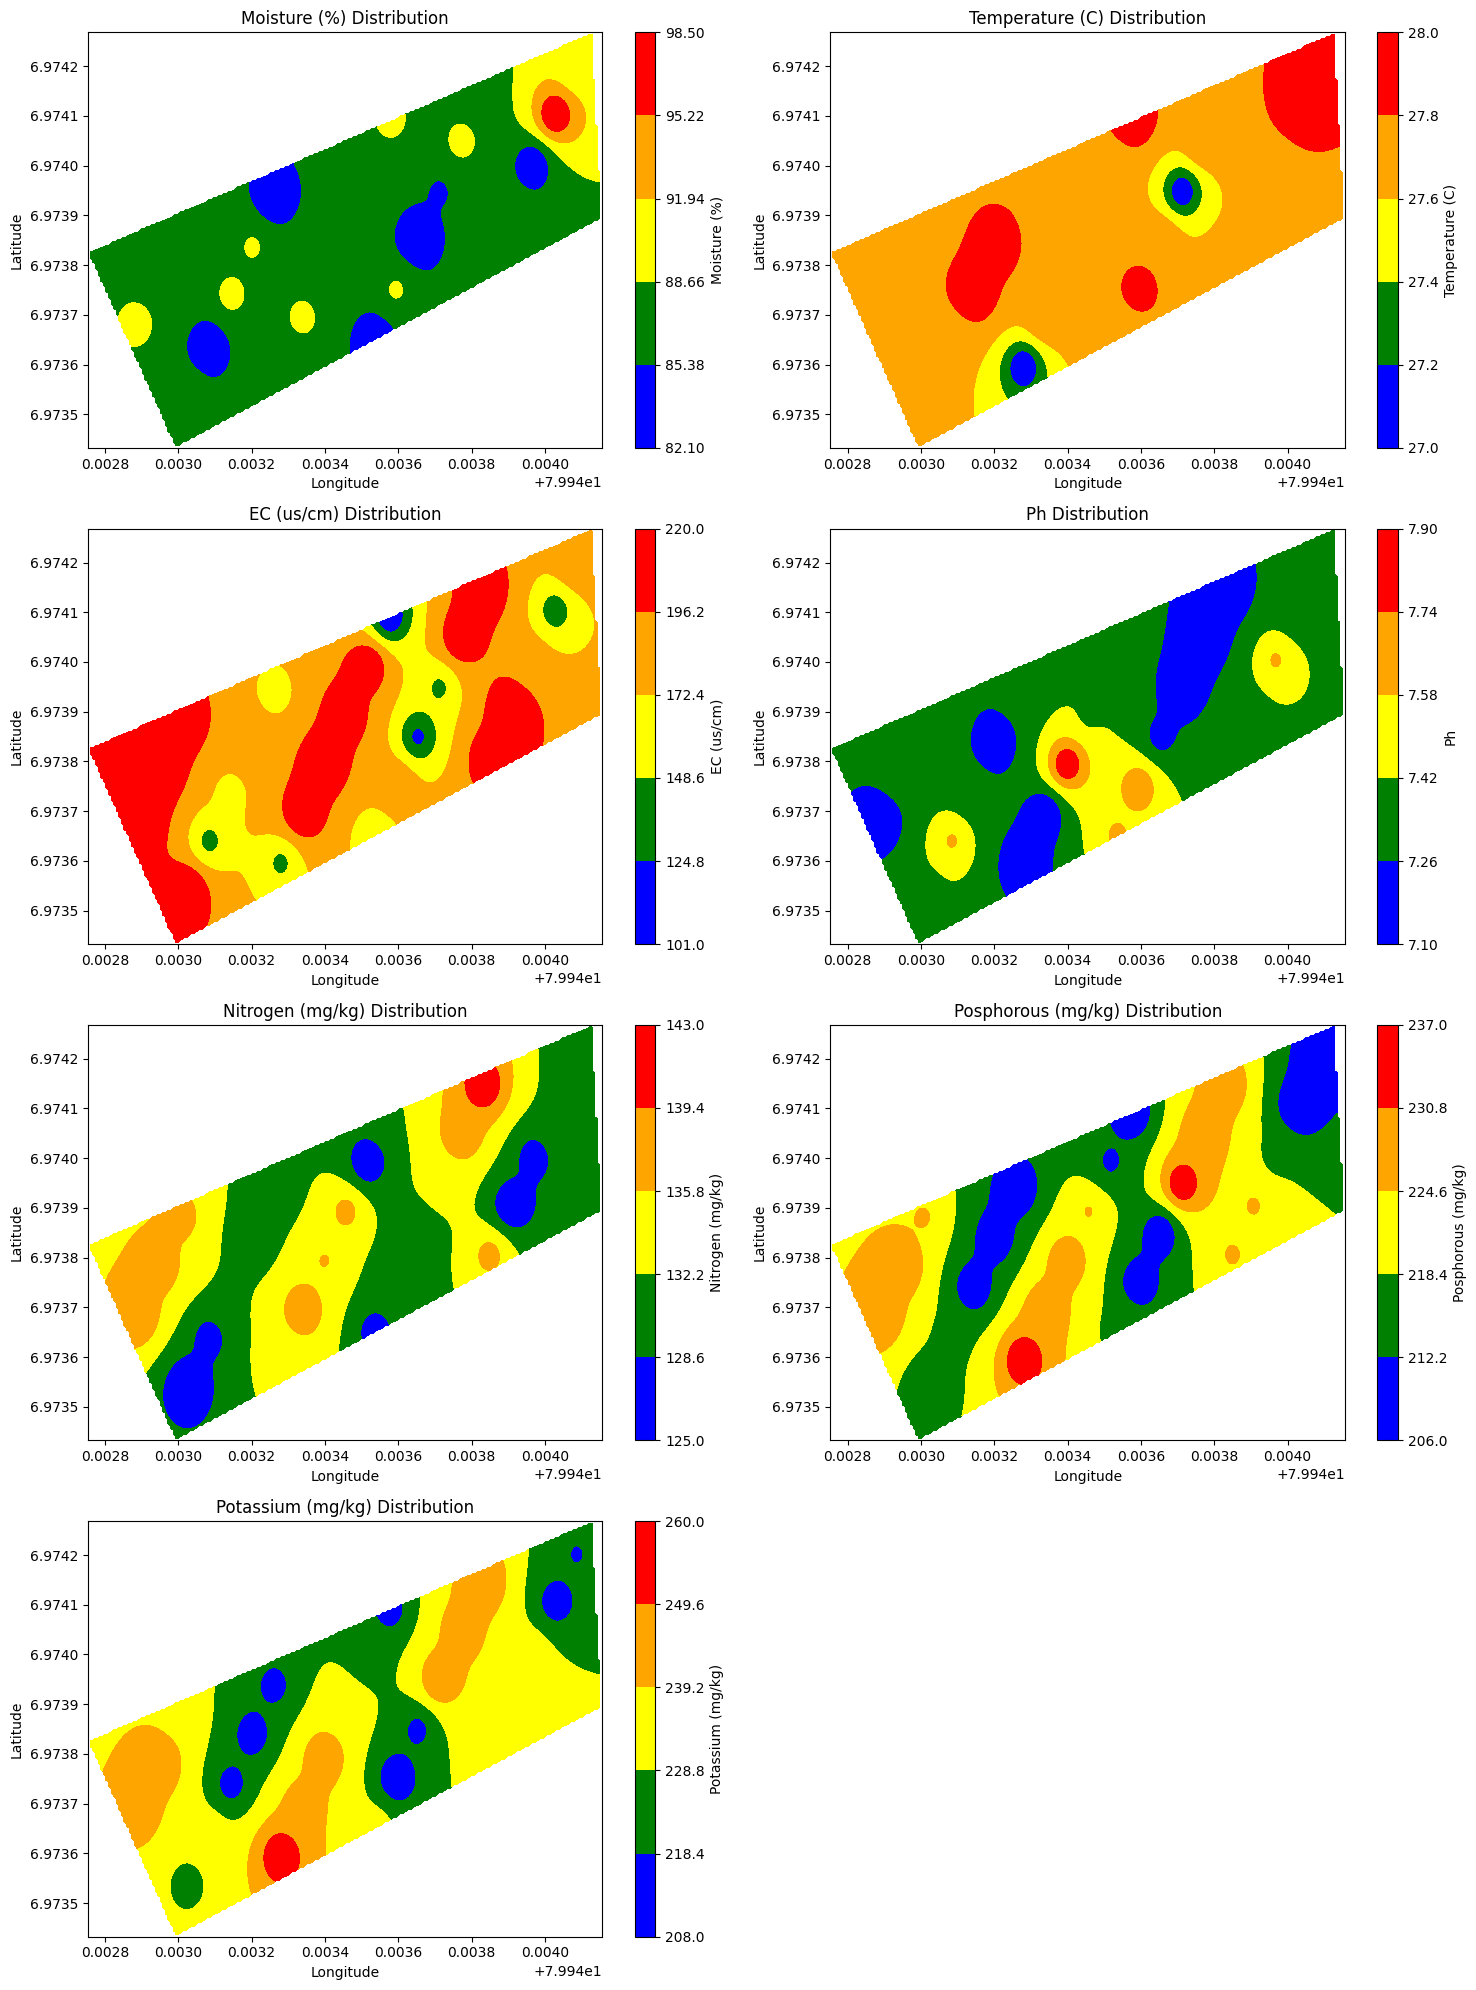

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter

parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']


def idw(x, y, z, xi, yi, power=2):
    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 + (y[:, None, None] - yi[None, :, :])**2)
    
    dist[dist < 1e-10] = 1e-10
    weights = 1 / (dist**power)
    z_idw = np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)
    return z_idw


min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:200j, min_lon:max_lon:200j] 

nrows = len(parameters) // 2 if len(parameters) % 2 == 0 else (len(parameters) // 2) + 1
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()

for i, parameter in enumerate(parameters):
    
    x = dataset_df['Latitude'].values
    y = dataset_df['Longitude'].values
    z = dataset_df[parameter].values

    
    grid_z_idw = idw(x, y, z, grid_x, grid_y) 
    grid_z_idw = gaussian_filter(grid_z_idw, sigma=1)
 
    mask = np.array([Point(lat, lon).within(polygon) for lat, lon in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_idw = np.ma.masked_array(grid_z_idw, ~mask.reshape(grid_z_idw.shape))

    
    min_val = np.min(z)
    max_val = np.max(z)
    
    
    bounds = np.linspace(min_val, max_val, 6)
    cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])  
    norm = BoundaryNorm(bounds, cmap.N)
    
    
    contour = axs[i].contourf(grid_y, grid_x, grid_z_idw, levels=bounds, cmap=cmap, norm=norm)
    fig.colorbar(contour, ax=axs[i], label=parameter)
    axs[i].set_title(f'{parameter} Distribution')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')


if len(parameters) % 2 != 0:
    fig.delaxes(axs[-1])


plt.tight_layout()
plt.show()


### IDW with raw

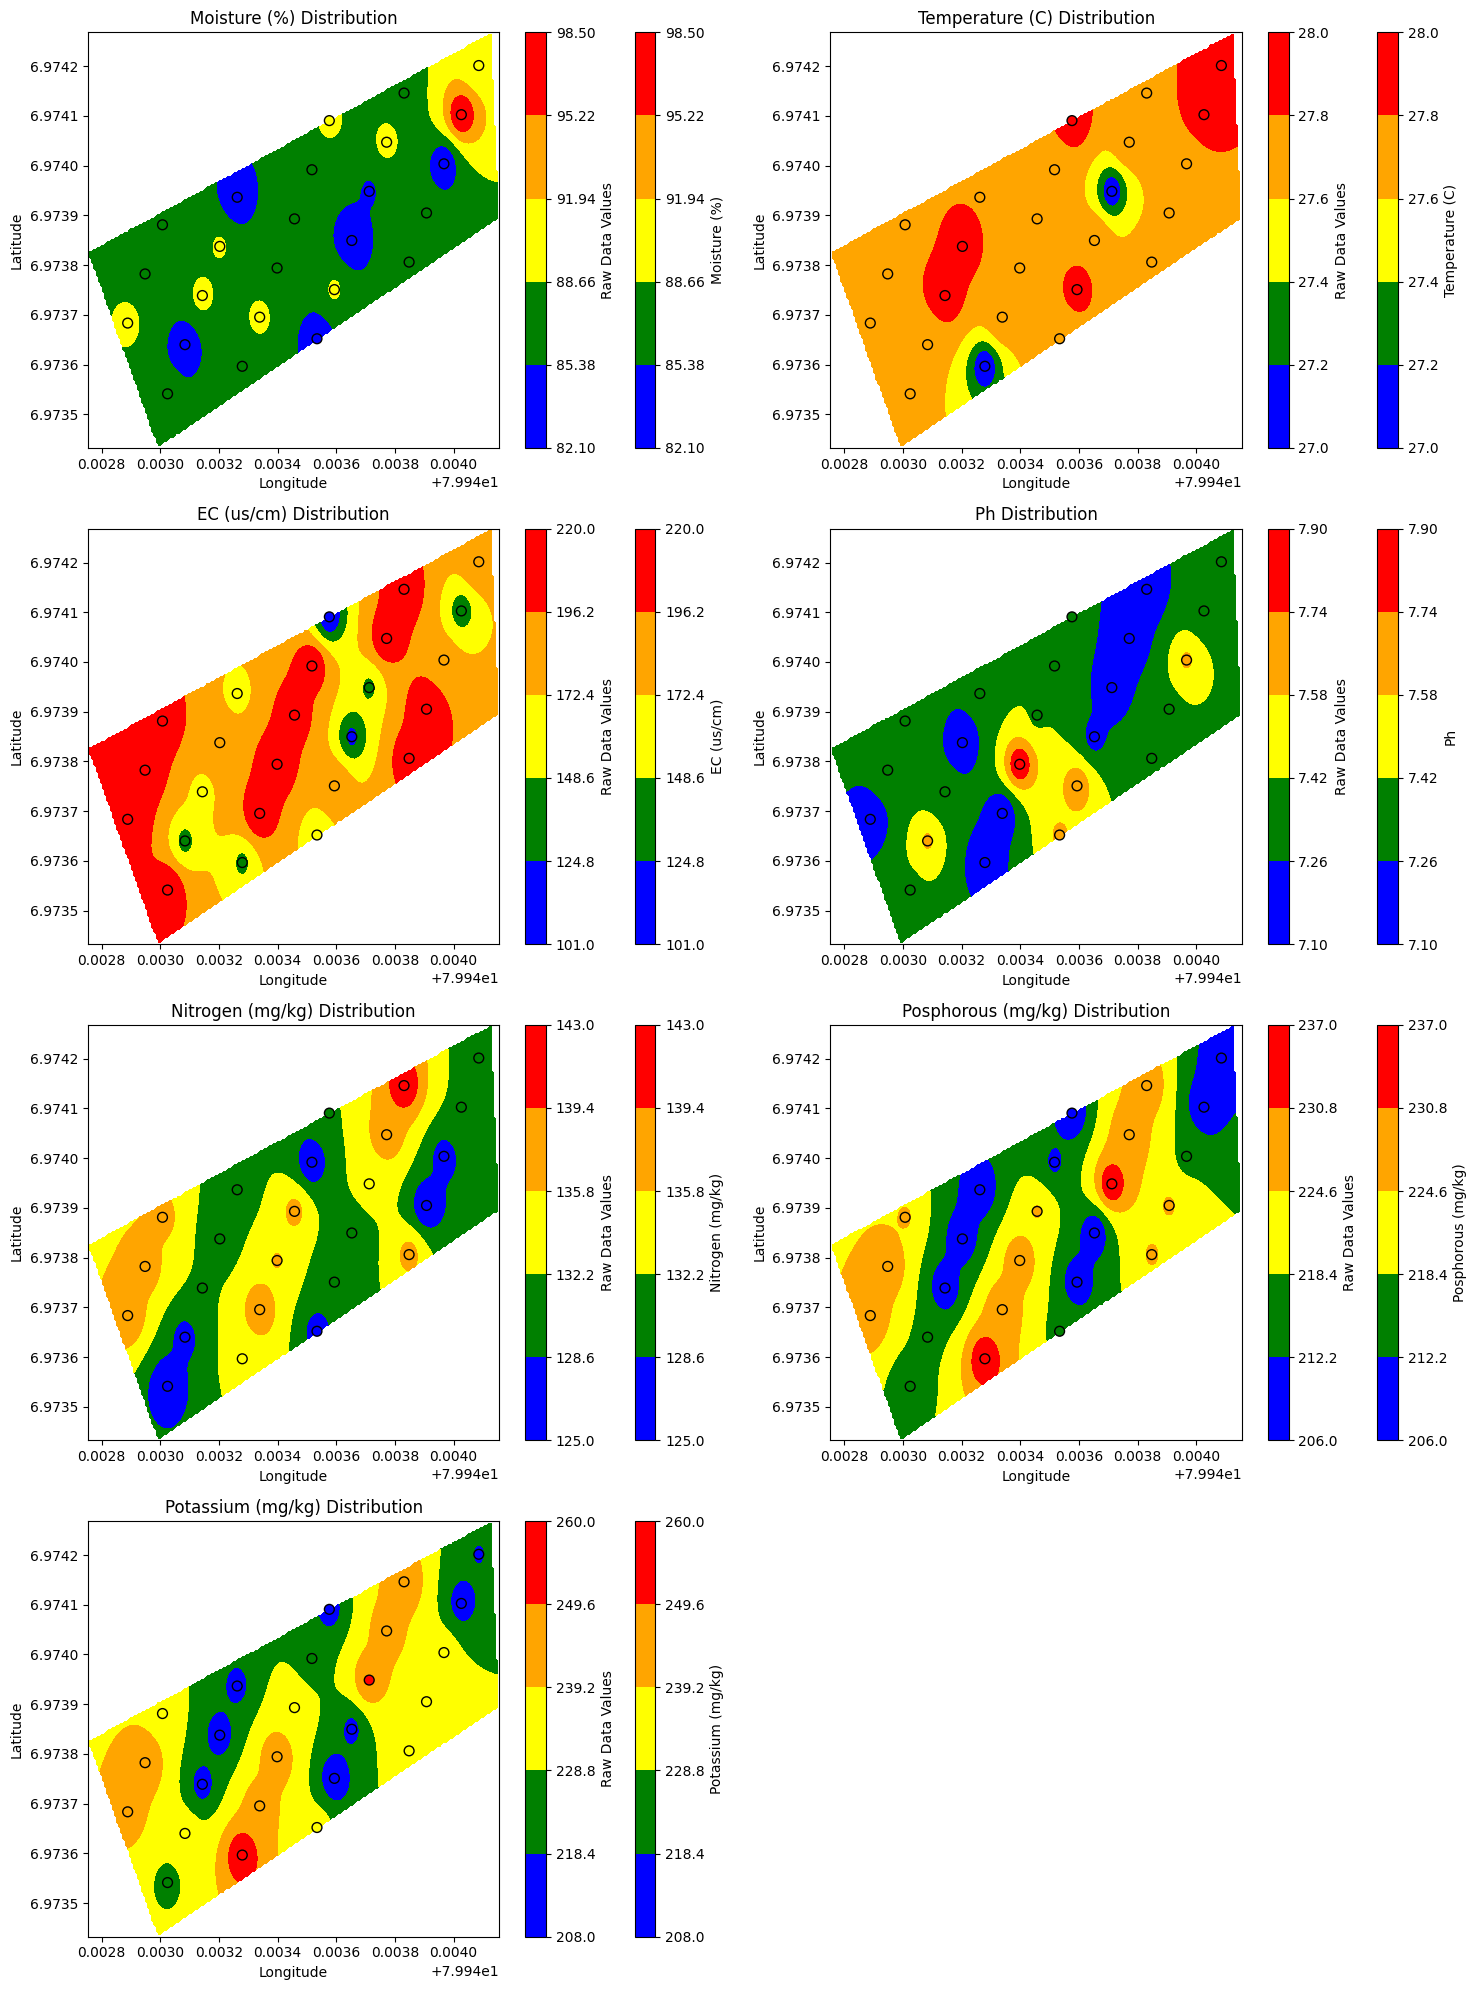

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter

# Define your parameters
parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']

def idw(x, y, z, xi, yi, power=2):
    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 + (y[:, None, None] - yi[None, :, :])**2)
    dist[dist < 1e-10] = 1e-10  # Avoid division by zero
    weights = 1 / (dist**power)
    z_idw = np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)
    return z_idw

min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:200j, min_lon:max_lon:200j]

nrows = (len(parameters) + 1) // 2  
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()

for i, parameter in enumerate(parameters):
    # Extract data for interpolation
    x = dataset_df['Latitude'].values
    y = dataset_df['Longitude'].values
    z = dataset_df[parameter].values

    # Apply IDW interpolation
    grid_z_idw = idw(x, y, z, grid_x, grid_y)
    grid_z_idw = gaussian_filter(grid_z_idw, sigma=1)  

    # Apply mask for values outside the polygon
    mask = np.array([Point(lon, lat).within(polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_idw = np.ma.masked_array(grid_z_idw, ~mask.reshape(grid_z_idw.shape))

    # Set color mapping
    min_val = np.min(z)
    max_val = np.max(z)
    bounds = np.linspace(min_val, max_val, 6)
    cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the interpolated contour map
    contour = axs[i].contourf(grid_y, grid_x, grid_z_idw, levels=bounds, cmap=cmap, norm=norm)
    fig.colorbar(contour, ax=axs[i], label=parameter)
    axs[i].set_title(f'{parameter} Distribution')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')

    # Plot raw data points on top
    sc = axs[i].scatter(y, x, c=z, cmap=cmap, norm=norm, edgecolor='black', marker='o', s=50, label='Raw Data')
    fig.colorbar(sc, ax=axs[i], label='Raw Data Values')


for ax in axs[len(parameters):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


### Krig

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.0
Full Sill: 1.5
Range: 0.1
Nugget: 0.5 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Moisture (%) - Min interpolated: 87.0459734022913, Max interpolated: 87.6402140218889
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.0
Full Sill: 1.5
Range: 0.1
Nugget: 0.5 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Temperature (C) - Min interpolated: 27.696631799723747, Max interpolated: 27.7279271034178
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.0
Full Sill: 1.5
Range: 0.1
Nugget: 0.5 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

EC (us/cm)

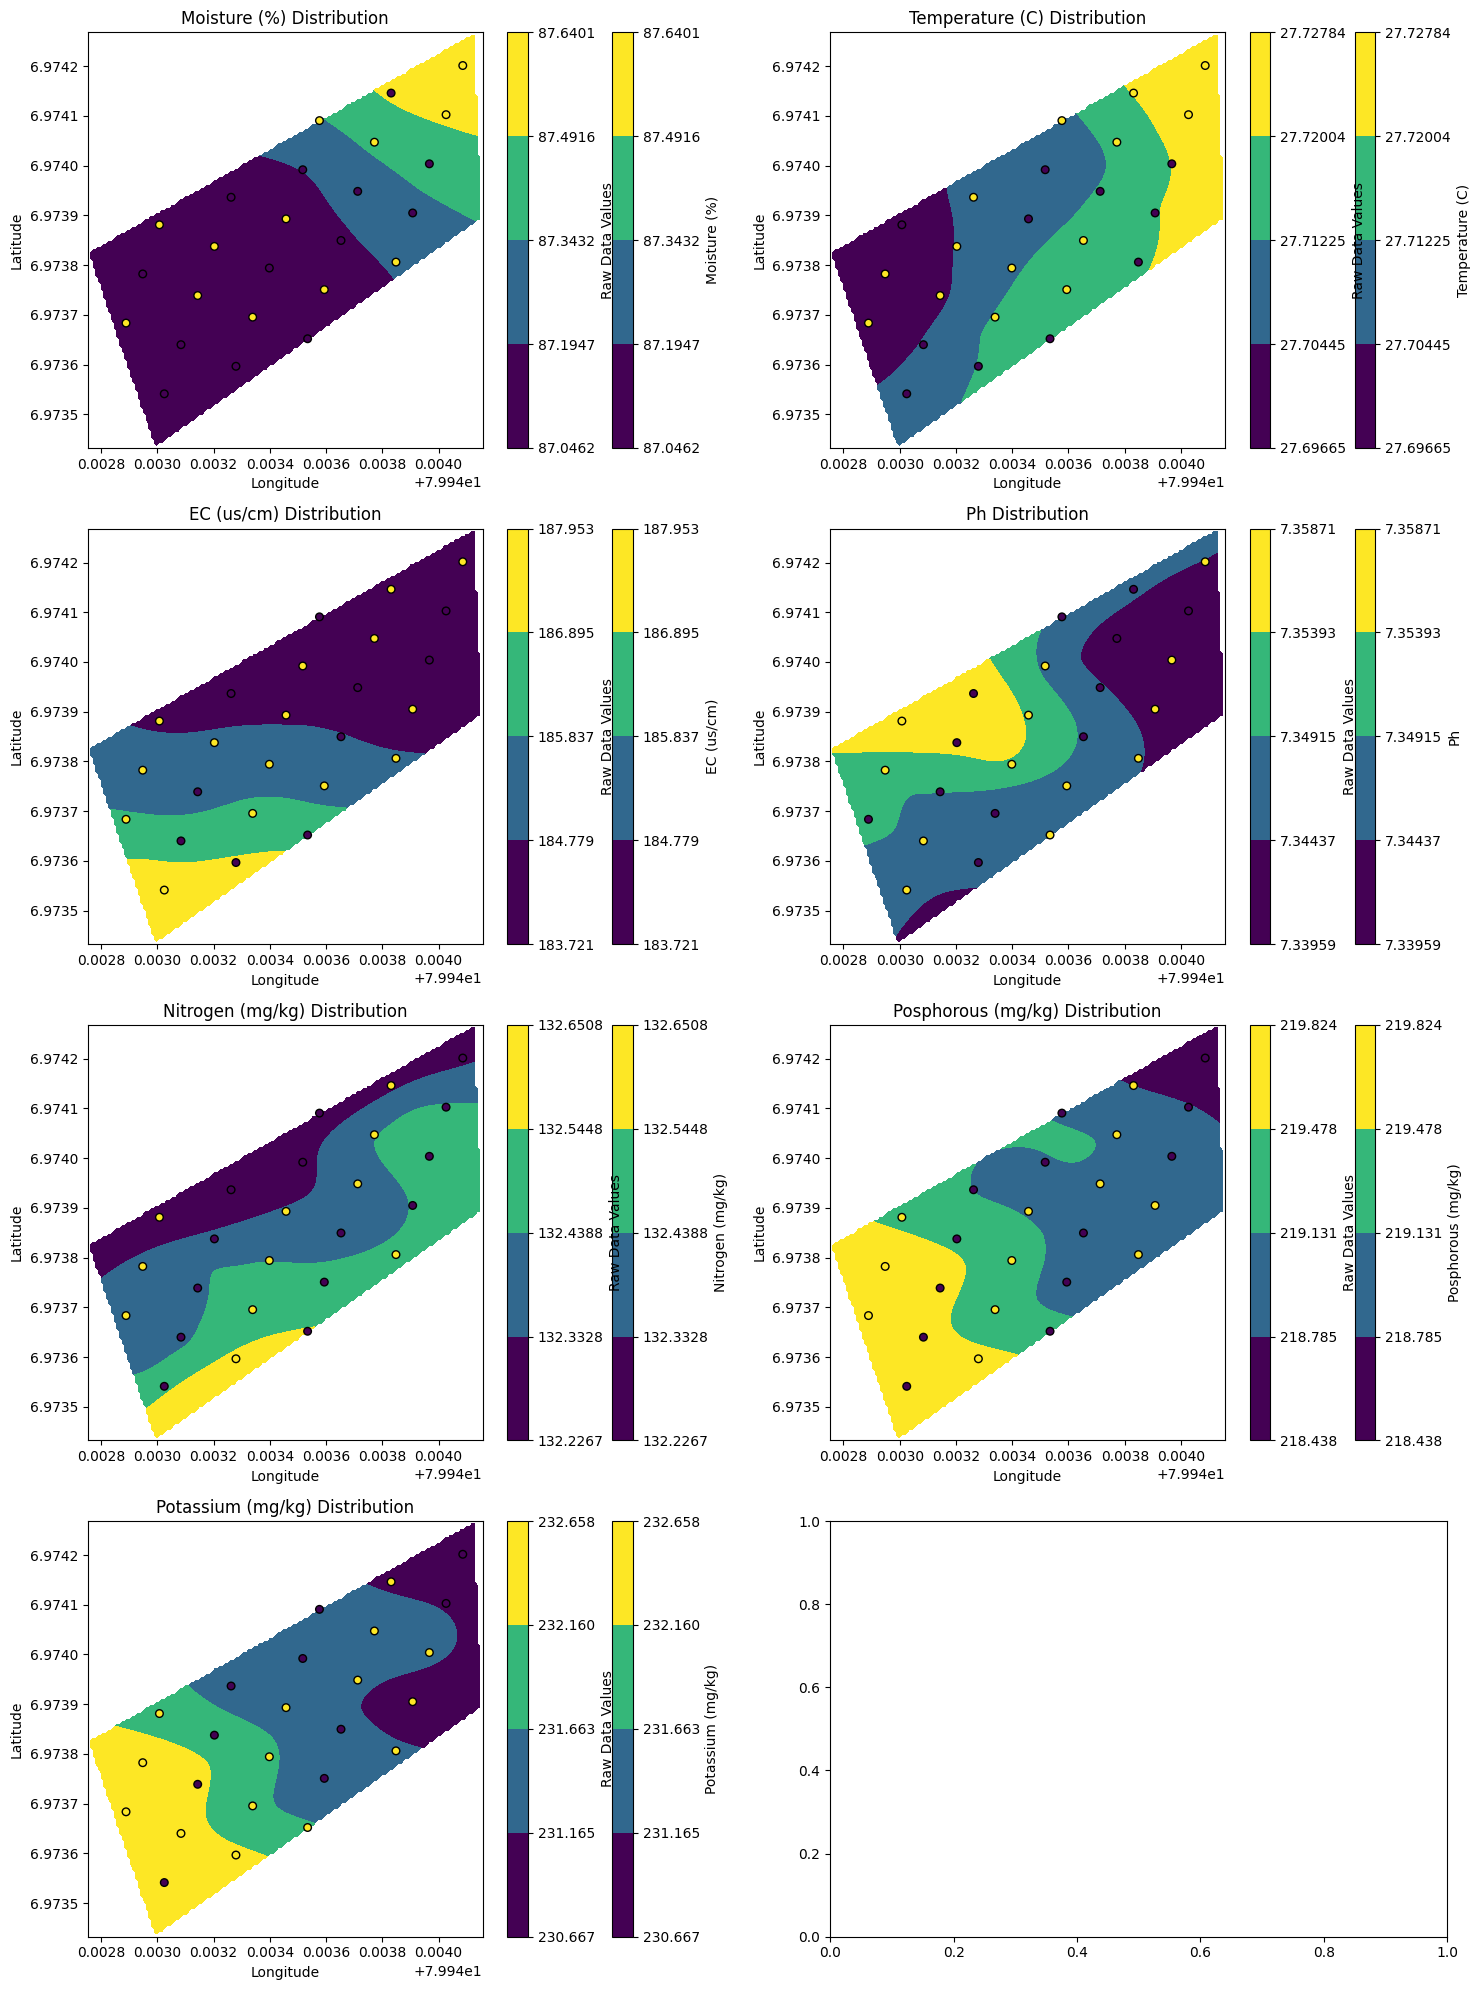

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point, Polygon
from scipy.ndimage import gaussian_filter

# Assuming dataset_df and boundary_df are already defined

# Convert boundary corners into coordinates and create polygon
coordinates = [tuple(map(float, corner.split(','))) for corner in boundary_df['Corners']]
if coordinates[0] != coordinates[-1]:
    coordinates.append(coordinates[0])  # Close the polygon
polygon = Polygon(coordinates)

parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']

min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:150j, min_lon:max_lon:150j]  

nrows = (len(parameters) + 1) // 2  # Ensures enough rows for all parameters
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()

for i, parameter in enumerate(parameters):
    x = dataset_df['Latitude'].values
    y = dataset_df['Longitude'].values
    z = dataset_df[parameter].values

    ok = OrdinaryKriging(
        x, y, z,
        variogram_model='exponential', 
        variogram_parameters={'range': 0.1, 'sill': 1.5, 'nugget': 0.5},  
        verbose=True,
        enable_plotting=False
    )


    z_pred, ss = ok.execute('grid', grid_x[:,0], grid_y[0,:])
    z_pred = z_pred.reshape(grid_x.shape)
    z_pred = gaussian_filter(z_pred, sigma=2)  

    
    print(f"{parameter} - Min interpolated: {z_pred.min()}, Max interpolated: {z_pred.max()}")

    # Mask values outside the polygon
    mask = np.array([Point(lon, lat).within(polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    z_pred = np.ma.masked_array(z_pred, ~mask.reshape(grid_x.shape))

    # Adjust bounds and color mapping
    min_val, max_val = z_pred.min(), z_pred.max()
    bounds = np.linspace(min_val, max_val, 5)  # Reduced number of levels to 5
    cmap = plt.cm.viridis  
    norm = BoundaryNorm(bounds, cmap.N)

    contour = axs[i].contourf(grid_y, grid_x, z_pred, levels=bounds, cmap=cmap, norm=norm)
    fig.colorbar(contour, ax=axs[i], label=parameter)
    axs[i].set_title(f'{parameter} Distribution')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')

    # Plot raw data points on top to compare with interpolation
    axs[i].scatter(y, x, c=z, cmap=cmap, norm=norm, edgecolor='black', marker='o', s=30, label='Raw Data')
    fig.colorbar(axs[i].collections[0], ax=axs[i], label='Raw Data Values')



plt.tight_layout()
plt.show()


### KNN and IDW

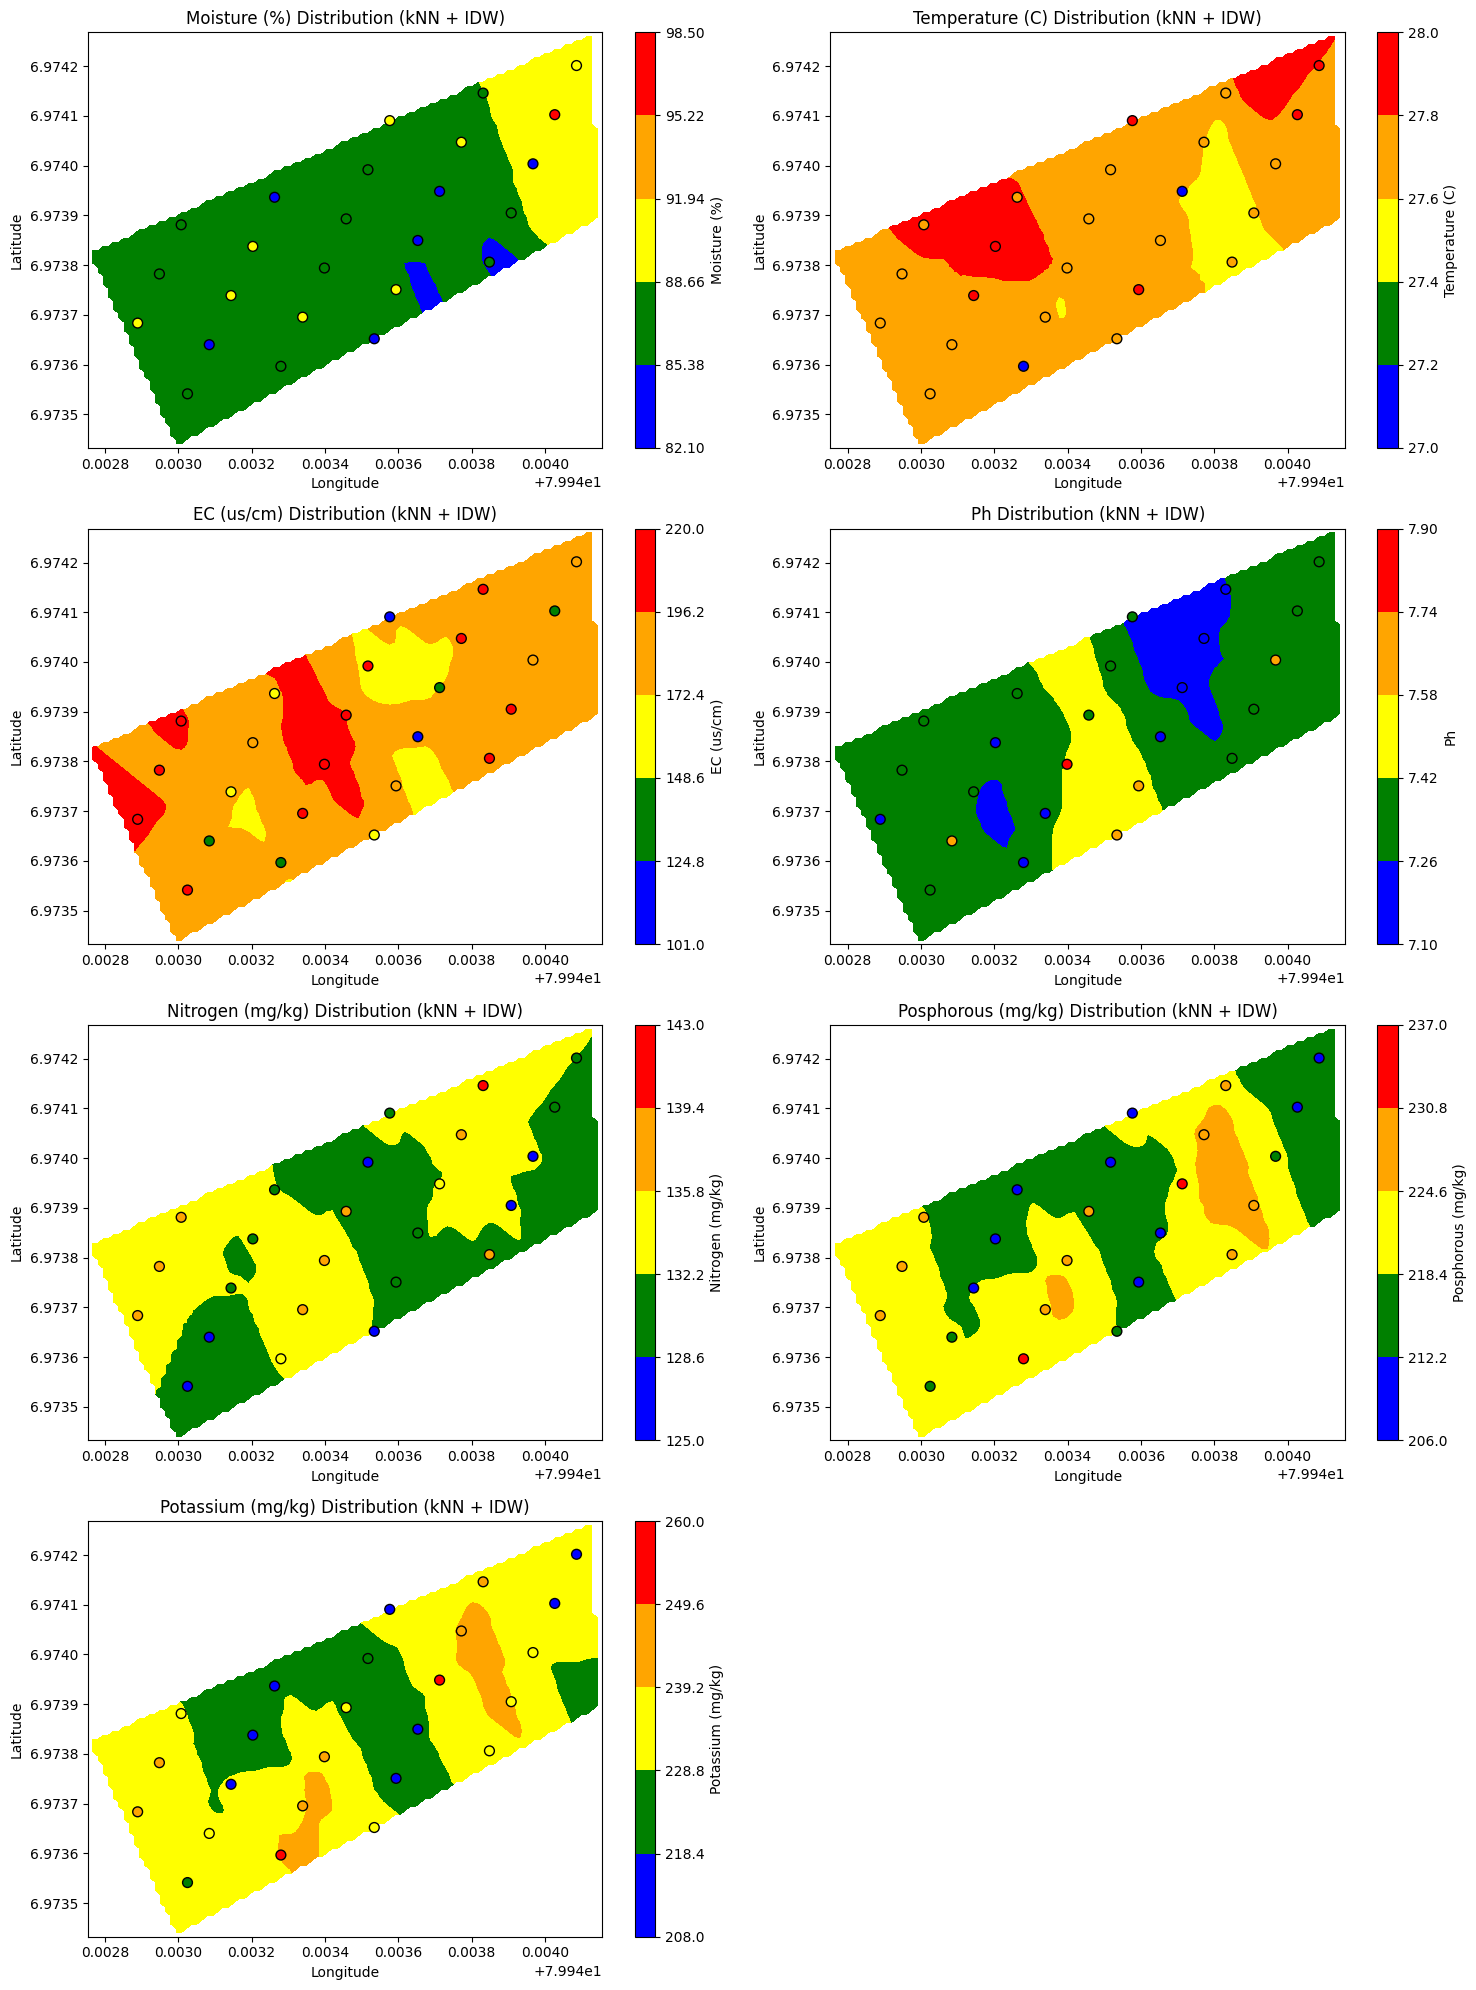

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Point, Polygon
from scipy.ndimage import gaussian_filter

# Assuming dataset_df and boundary_df are defined, and polygon is created from boundary_df

# Nutrient parameters to visualize
parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']

# Import KNeighborsRegressor for kNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  # kNN model with 5 neighbors

# Define Inverse Distance Weighting (IDW) function (no chunk processing for now)
def idw(x, y, z, xi, yi, power=2):
    """
    IDW interpolation function without chunk processing.
    """
    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 + (y[:, None, None] - yi[None, :, :])**2)
    dist[dist < 1e-10] = 1e-10 
    weights = 1 / (dist**power)
    z_idw = np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)
    return z_idw

# Get bounds from polygon and create grid
min_lat, min_lon, max_lat, max_lon = polygon.bounds
grid_x, grid_y = np.mgrid[min_lat:max_lat:100j, min_lon:max_lon:100j]  # Reduced grid resolution (100x100)

# Define number of rows and columns for subplots
nrows = len(parameters) // 2 if len(parameters) % 2 == 0 else (len(parameters) // 2) + 1
ncols = 2

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()

# Loop through each parameter
for i, parameter in enumerate(parameters):
    x_train = dataset_df[['Latitude', 'Longitude']].values
    y_train = dataset_df[parameter].values

    # Fit the kNN model
    knn_model.fit(x_train, y_train)

    # Predict values on the grid using kNN
    grid_points = np.vstack([grid_x.flatten(), grid_y.flatten()]).T
    grid_z_knn = knn_model.predict(grid_points).reshape(grid_x.shape)

    # Perform IDW interpolation on the predicted kNN values
    grid_z_idw = idw(grid_x.flatten(), grid_y.flatten(), grid_z_knn.flatten(), grid_x, grid_y)

    # Apply Gaussian smoothing
    grid_z_idw = gaussian_filter(grid_z_idw, sigma=1)

    # Mask interpolation outside the polygon
    mask = np.array([Point(lat, lon).within(polygon) for lat, lon in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_idw = np.ma.masked_array(grid_z_idw, ~mask.reshape(grid_z_idw.shape))

    # Define color map and boundaries
    min_val = np.min(y_train)
    max_val = np.max(y_train)
    bounds = np.linspace(min_val, max_val, 6)
    cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot interpolated data
    contour = axs[i].contourf(grid_y, grid_x, grid_z_idw, levels=bounds, cmap=cmap, norm=norm)
    fig.colorbar(contour, ax=axs[i], label=parameter)

    # Scatter raw data points
    axs[i].scatter(x_train[:, 1], x_train[:, 0], c=y_train, cmap=cmap, norm=norm, edgecolor='black', marker='o', s=50, label='Raw Data')

    axs[i].set_title(f'{parameter} Distribution (kNN + IDW)')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')

# Remove unused subplots if any
if len(parameters) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


### spline interpola

Interpolating Parameters: 100%|██████████| 7/7 [00:19<00:00,  2.74s/it]


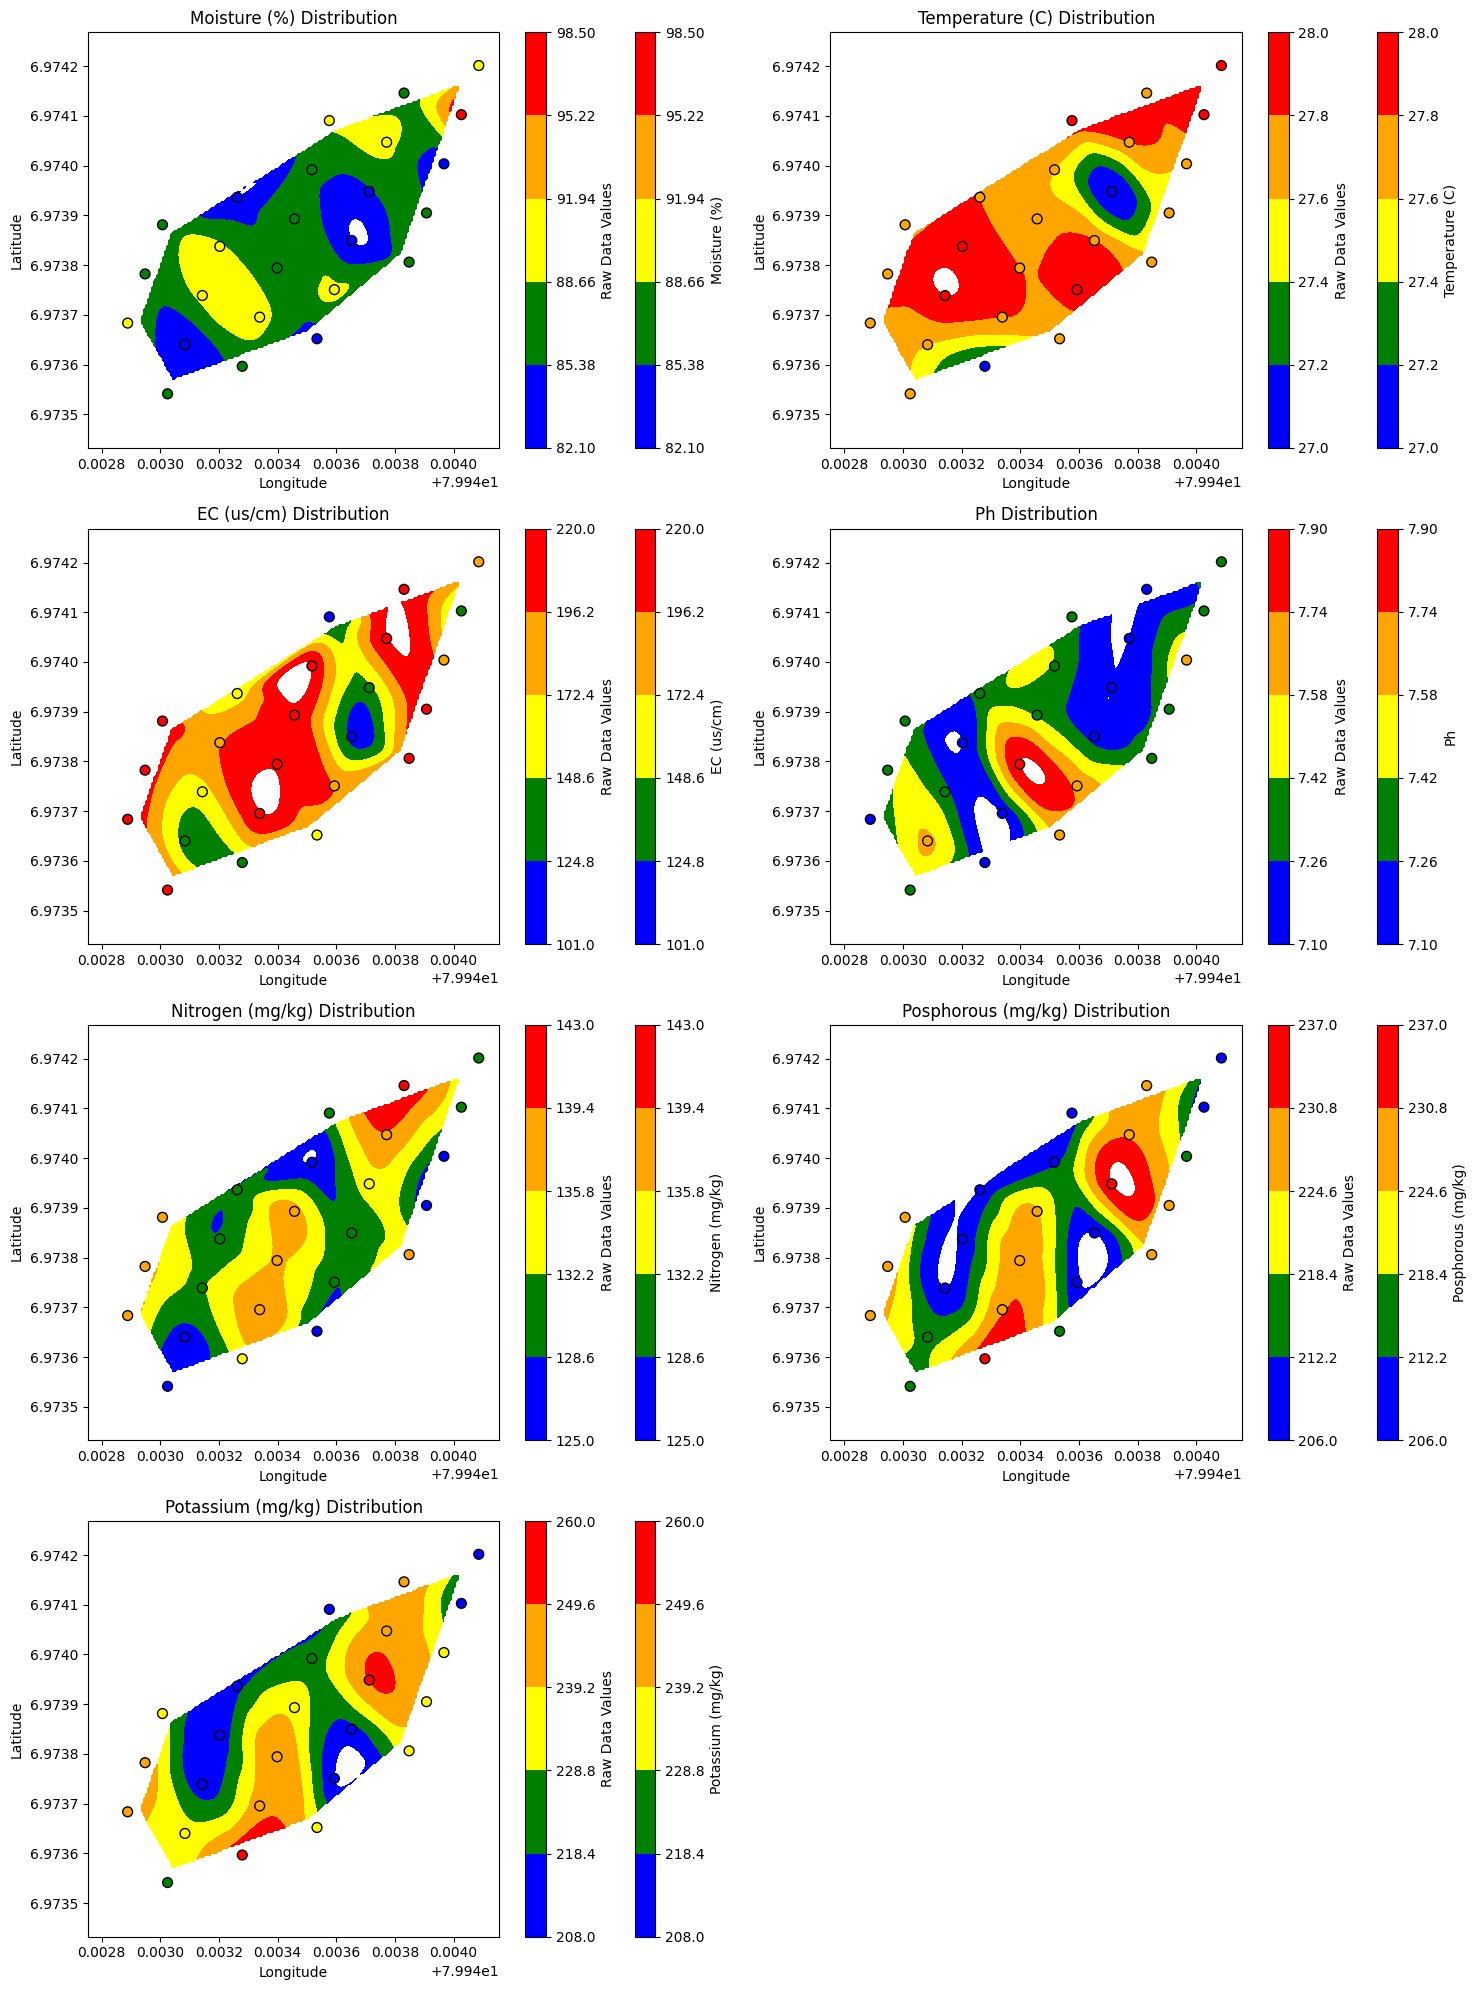

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Point
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from itertools import product
import pandas as pd
from tqdm import tqdm  


# Example parameters list (as provided)
parameters = ['Moisture (%)', 'Temperature (C)', 'EC (us/cm)', 'Ph', 
              'Nitrogen (mg/kg)', 'Posphorous (mg/kg)', 'Potassium (mg/kg)']

def spline_interpolation(x, y, z, xi, yi, method='cubic'):
    """
    Perform spline interpolation using scipy's griddata function.

    Parameters:
    - x, y: Arrays of coordinates of the known data points.
    - z: Array of known data values.
    - xi, yi: Meshgrid arrays defining the interpolation grid.
    - method: Interpolation method ('linear', 'cubic', 'nearest').

    Returns:
    - zi: Interpolated values on the grid.
    """
    points = np.column_stack((x, y))
    grid_z = griddata(points, z, (xi, yi), method=method)
    return grid_z

# Define your spatial bounds based on the polygon
min_lat, min_lon, max_lat, max_lon = polygon.bounds
# Define the grid resolution (e.g., 200x200)
grid_x, grid_y = np.mgrid[min_lat:max_lat:200j, min_lon:max_lon:200j]

# Determine subplot layout based on number of parameters
nrows = (len(parameters) + 1) // 2  
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
axs = axs.flatten()

for i, parameter in enumerate(tqdm(parameters, desc="Interpolating Parameters")):
    # Extract data for interpolation
    x = dataset_df['Latitude'].values
    y = dataset_df['Longitude'].values
    z = dataset_df[parameter].values

    # Handle cases where all z are NaN or have insufficient data
    if np.all(np.isnan(z)):
        print(f"All values are NaN for parameter: {parameter}. Skipping interpolation.")
        axs[i].set_visible(False)
        continue

    # Apply Spline interpolation
    grid_z_spline = spline_interpolation(x, y, z, grid_x, grid_y, method='cubic')

    # Apply Gaussian filter for smoothing (optional)
    grid_z_spline = gaussian_filter(grid_z_spline, sigma=1)  

    # Apply mask for values outside the polygon
    mask = np.array([Point(lon, lat).within(polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_spline = np.ma.masked_array(grid_z_spline, ~mask.reshape(grid_z_spline.shape))

    # Set color mapping
    min_val = np.nanmin(z)
    max_val = np.nanmax(z)
    bounds = np.linspace(min_val, max_val, 6)
    cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the interpolated contour map
    contour = axs[i].contourf(grid_y, grid_x, grid_z_spline, levels=bounds, cmap=cmap, norm=norm)
    fig.colorbar(contour, ax=axs[i], label=parameter)
    axs[i].set_title(f'{parameter} Distribution')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')

    # Plot raw data points on top
    sc = axs[i].scatter(y, x, c=z, cmap=cmap, norm=norm, edgecolor='black', marker='o', s=50, label='Raw Data')
    fig.colorbar(sc, ax=axs[i], label='Raw Data Values')

# Hide any unused subplots
for ax in axs[len(parameters):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
